# Evaluación Avanzada de Riesgo Crediticio - "Give Me Some Credit"
### Por: Antigravity (IA) para el Dr. Fuentes

Este notebook presenta un flujo de trabajo de Ciencia de Datos de alto nivel. Abordaremos el problema de clasificación binaria para predecir si un prestatario experimentará dificultades financieras graves en los próximos dos años.

**Objetivos Educativos:**
1. Limpieza e ingeniería de variables sofisticada (Imputación Iterativa).
2. Benchmarking rápido con **LazyClassifier**.
3. Automatización de tuberías con **AutoML (TPOT)**.
4. Optimización de hiperparámetros con **Búsqueda Tradicional** y **Optuna**.
5. Interpretación de modelos de "Caja Negra" (MLP) mediante **SHAP**.
6. Análisis comparativo de métricas **AUC-ROC**.

## 1. Configuración y Descarga de Datos

Utilizaremos la configuración local de la API de Kaggle para descargar el dataset.

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from sklearn.metrics import roc_auc_score
import warnings

warnings.filterwarnings('ignore')
load_dotenv() # Carga variables desde .env si existen

print("✅ Entorno inicializado. La API de Kaggle utilizará la configuración local en ~/.kaggle/kaggle.json.")

✅ Entorno inicializado. La API de Kaggle utilizará la configuración local en ~/.kaggle/kaggle.json.


In [2]:
# Descarga del dataset de la competencia
try:
    !mkdir -p ../data/credit
    !kaggle competitions download -c GiveMeSomeCredit -p ../data/credit
    !unzip -o ../data/credit/GiveMeSomeCredit.zip -d ../data/credit
    print("✅ Archivos descargados y descomprimidos en ../data/credit/")
except Exception as e:
    print(f"⚠️ Error durante la descarga: {e}")

GiveMeSomeCredit.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ../data/credit/GiveMeSomeCredit.zip
  inflating: ../data/credit/Data Dictionary.xls  
  inflating: ../data/credit/cs-test.csv  
  inflating: ../data/credit/cs-training.csv  
  inflating: ../data/credit/sampleEntry.csv  
✅ Archivos descargados y descomprimidos en ../data/credit/


## 2. Carga y Exploración Inicial

In [3]:
df = pd.read_csv('../data/credit/cs-training.csv').drop(columns=['Unnamed: 0'])

print(f"Dimensiones del dataset: {df.shape}")
df.head()

Dimensiones del dataset: (150000, 11)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


Observamos la distribución del target (`SeriousDlqin2yrs`). El crédito suele ser un problema de clases desbalanceadas.

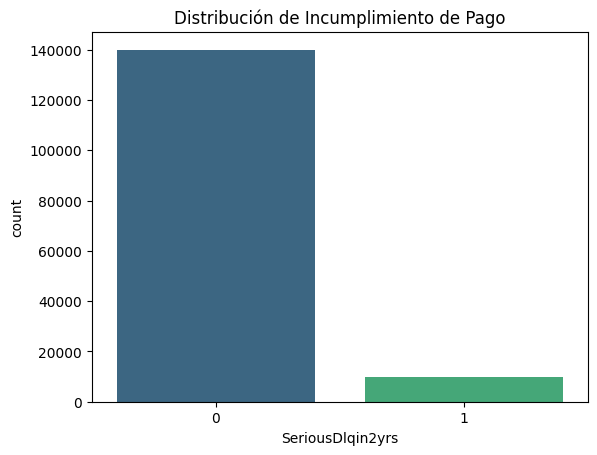

Proporción de clases:
SeriousDlqin2yrs
0    0.93316
1    0.06684
Name: proportion, dtype: float64


In [4]:
sns.countplot(x='SeriousDlqin2yrs', data=df, palette='viridis')
plt.title('Distribución de Incumplimiento de Pago')
plt.show()

print("Proporción de clases:")
print(df['SeriousDlqin2yrs'].value_counts(normalize=True))

## 3. Ingeniería de Variables y Limpieza Sophisticada

En lugar de una simple imputación por la mediana, utilizaremos **IterativeImputer** (MICE de Scikit-Learn) para estimar valores nulos basándonos en otras variables. También manejaremos valores atípicos extremos que son comunes en este dataset (ej. `DebtRatio` o `age`=0).

In [5]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 1. Manejo de Outliers (Truncamiento/Winsorización manual por conocimiento de dominio)
def clean_outliers(data):
    # Edades improbables
    data.loc[data['age'] < 18, 'age'] = data['age'].median()
    
    # Utilización de líneas de crédito > 1 a veces representan errores o situaciones extremas
    p99_util = data['RevolvingUtilizationOfUnsecuredLines'].quantile(0.99)
    data.loc[data['RevolvingUtilizationOfUnsecuredLines'] > p99_util, 'RevolvingUtilizationOfUnsecuredLines'] = p99_util
    
    # DebtRatio: Valores extremadamente altos pueden ser errores de captura si no hay ingresos
    p99_debt = data['DebtRatio'].quantile(0.99)
    data.loc[data['DebtRatio'] > p99_debt, 'DebtRatio'] = p99_debt
    
    return data

df_cleaned = clean_outliers(df.copy())

# 2. Imputación Iterativa para MonthlyIncome y NumberOfDependents
imputer = IterativeImputer(random_state=42, max_iter=10)
df_imputed = pd.DataFrame(imputer.fit_transform(df_cleaned), columns=df_cleaned.columns)

print("Valores nulos después de imputación:")
print(df_imputed.isnull().sum().sum())

Valores nulos después de imputación:
0


## 4. Benchmarking con LazyClassifier

Antes de profundizar, veamos qué modelos base rinden mejor de forma predeterminada.

In [6]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

X = df_imputed.drop(columns=['SeriousDlqin2yrs'])
y = df_imputed['SeriousDlqin2yrs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Usamos una muestra para agilizar el LazyClassifier en la demostración
X_train_sample = X_train.sample(5000, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

X_test_sample = X_test.sample(2000, random_state=42)
y_test_sample = y_test.loc[X_test_sample.index]

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models_summary, predictions = clf.fit(X_train_sample, X_test_sample, y_train_sample, y_test_sample)

models_summary.head(10)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 347, number of negative: 4653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 971
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069400 -> initscore=-2.595943
[LightGBM] [Info] Start training from score -2.595943


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
Perceptron,0.85,0.72,0.72,0.88,0.01
BernoulliNB,0.94,0.72,0.72,0.94,0.01
NearestCentroid,0.77,0.72,0.72,0.83,0.01
QuadraticDiscriminantAnalysis,0.93,0.68,0.68,0.93,0.01
PassiveAggressiveClassifier,0.93,0.64,0.64,0.93,0.01
XGBClassifier,0.94,0.63,0.63,0.93,0.14
DecisionTreeClassifier,0.90,0.63,0.63,0.91,0.06
LGBMClassifier,0.94,0.62,0.62,0.93,0.45
LinearDiscriminantAnalysis,0.94,0.60,0.60,0.92,0.01


## 5. AutoML con TPOT

TPOT busca la mejor tubería de procesamiento utilizando algoritmos genéticos. Lo limitamos a 2 minutos para esta demostración considerando su entorno MacOS.

In [7]:
from tpot import TPOTClassifier


tpot = TPOTClassifier(search_space='linear-light', 
                      scorers=['roc_auc'], 
                      generations=2, 
                      population_size=10, 
                      verbose=2, 
                      random_state=42, 
                      max_time_mins=2, 
                      n_jobs=1)
tpot.fit(X_train_sample, y_train_sample)


Generation:   0%|          | 0/2 [00:00<?, ?it/s]/Users/gus/trabajo/academia/improved-potato/.venv/lib/python3.13/site-packages/stopit/__init__.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Generation: 100%|██████████| 2/2 [00:23<00:00, 11.91s/it]


,search_space,<tpot.search_...t 0x124462e40>
,scorers,['roc_auc']
,scorers_weights,[1]
,cv,10
,other_objective_functions,[]
,other_objective_functions_weights,[]
,objective_function_names,None
,bigger_is_better,True
,categorical_features,None
,memory,None
,preprocessing,False


In [12]:
print(f"Métrica AUC en Test (TPOT): ",roc_auc_score(y_score=tpot.predict_proba(X_test_sample)[:,1],y_true=y_test_sample))

Métrica AUC en Test (TPOT):  0.8532165777949029


In [13]:
tpot.fitted_pipeline_

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('standardscaler', ...), ('variancethreshold', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"threshold threshold: float, default=0Features with a training-set variance lower than this threshold willbe removed. The default is to keep all features with non-zero variance,i.e. remove the features that have the same value in all samples.",0.0378168026136
,"transformer_list transformer_list: list of (str, transformer) tuplesList of transformer objects to be applied to the data. The firsthalf of each tuple is the name of the transformer. The transformer canbe 'drop' for it to be ignored or can be 'passthrough' for features tobe passed unchanged... versionadded:: 1.1 Added the option `""passthrough""`... versionchanged:: 0.22 Deprecated `None` as a transformer in favor of 'drop'.","[('skiptransformer', ...), ('passthrough', ...)]"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer.Keys are transformer names, values the weights.Raises ValueError if key not present in ``transformer_list``.",None


## 6. Modelado Tradicional con Hiperparámetros Sofisticados

Entrenaremos **Regresión Logística (LR)**, **Árbol de Decisión (DT)** y **Multilayer Perceptron (MLP)**.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Escalamiento requerido para LR y MLP
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Logistic Regression (Grid Search)
lr_params = {'C': [0.1, 1, 10], 'penalty': ['l2']}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=3, scoring='roc_auc')
lr_grid.fit(X_train_scaled, y_train)

# 2. Decision Tree (Grid Search)
dt_params = {'max_depth': [5, 10, 15], 'min_samples_split': [10, 50, 100]}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=3, scoring='roc_auc')
dt_grid.fit(X_train, y_train)

# 3. MLP (Grid Search)
mlp_params = {'hidden_layer_sizes': [(50,), (100, 50)], 'alpha': [0.0001, 0.01]}
mlp_grid = GridSearchCV(MLPClassifier(max_iter=300, random_state=42), mlp_params, cv=3, scoring='roc_auc')
mlp_grid.fit(X_train_scaled[:20000], y_train[:20000])

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",MLPClassifier...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'alpha': [0.0001, 0.01], 'hidden_layer_sizes': [(50,), (100, ...)]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also

## 7. Ejercicio Avanzado: Optimización con Optuna

Optuna permite una búsqueda Bayesiana dinámica.

In [15]:
import optuna
from sklearn.metrics import roc_auc_score

def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 2)
    layers = [trial.suggest_int(f'n_units_l{i}', 20, 100) for i in range(n_layers)]
    alpha = trial.suggest_float('alpha', 1e-5, 1e-1, log=True)
    
    model = MLPClassifier(hidden_layer_sizes=tuple(layers), alpha=alpha, random_state=42, max_iter=200)
    model.fit(X_train_scaled[:10000], y_train[:10000])
    preds = model.predict_proba(X_test_scaled[:2000])[:,1]
    return roc_auc_score(y_test[:2000], preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

print("🚀 Mejores Hiperparámetros (Optuna):", study.best_params)

[I 2026-02-25 21:11:33,593] A new study created in memory with name: no-name-3fe6f6ef-f916-44f8-a2f5-1a689a6ad471
[I 2026-02-25 21:11:35,227] Trial 0 finished with value: 0.8666569363797021 and parameters: {'n_layers': 1, 'n_units_l0': 70, 'alpha': 0.0012657765427222787}. Best is trial 0 with value: 0.8666569363797021.
[I 2026-02-25 21:11:38,522] Trial 1 finished with value: 0.8288311032567534 and parameters: {'n_layers': 2, 'n_units_l0': 90, 'n_units_l1': 44, 'alpha': 0.002431483861595804}. Best is trial 0 with value: 0.8666569363797021.
[I 2026-02-25 21:11:39,917] Trial 2 finished with value: 0.8670159050744762 and parameters: {'n_layers': 1, 'n_units_l0': 51, 'alpha': 0.002656047801023671}. Best is trial 2 with value: 0.8670159050744762.
[I 2026-02-25 21:11:42,163] Trial 3 finished with value: 0.8509530421610705 and parameters: {'n_layers': 2, 'n_units_l0': 20, 'n_units_l1': 86, 'alpha': 0.07696739354492693}. Best is trial 2 with value: 0.8670159050744762.
[I 2026-02-25 21:11:43,612

🚀 Mejores Hiperparámetros (Optuna): {'n_layers': 1, 'n_units_l0': 51, 'alpha': 0.002656047801023671}


## 8. Evaluación y Visualización de Métricas

### Comparativa Train vs Test por Modelo

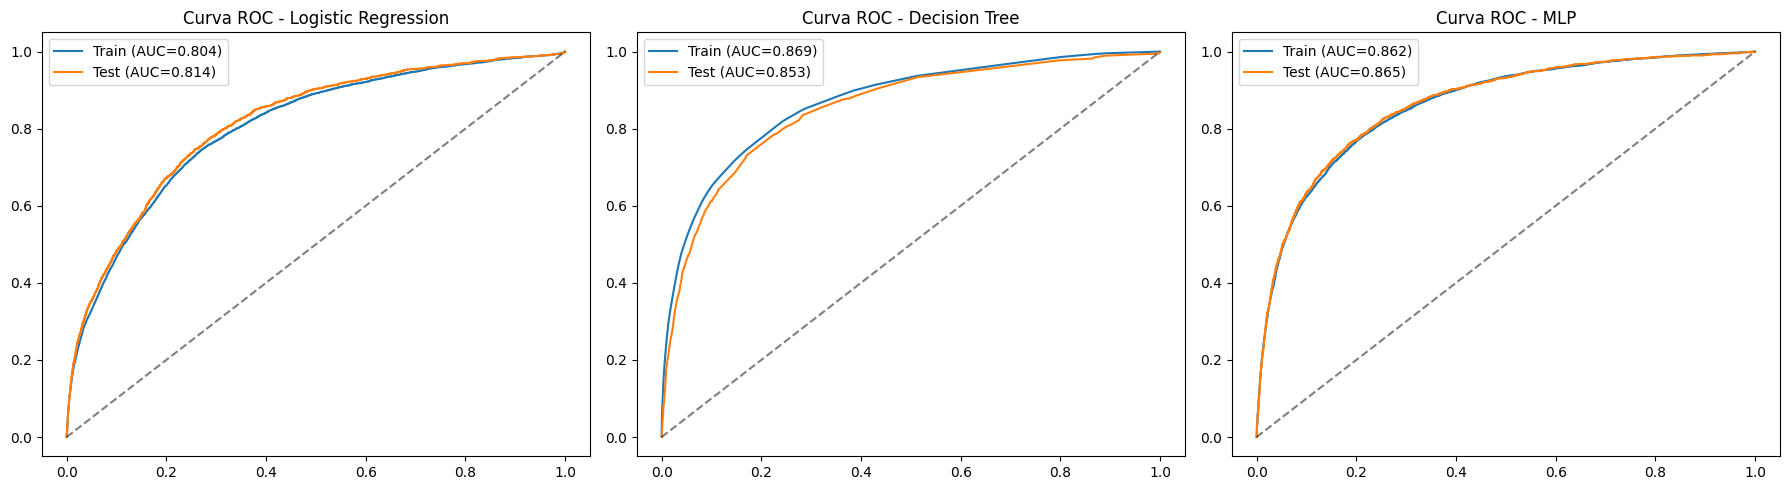

In [16]:
from sklearn.metrics import roc_curve, auc

final_models = {
    'Logistic Regression': lr_grid.best_estimator_,
    'Decision Tree': dt_grid.best_estimator_,
    'MLP': mlp_grid.best_estimator_
}

plt.figure(figsize=(18, 5))

for i, (name, model) in enumerate(final_models.items()):
    plt.subplot(1, 3, i+1)
    
    X_tr = X_train_scaled if name in ['Logistic Regression', 'MLP'] else X_train
    X_te = X_test_scaled if name in ['Logistic Regression', 'MLP'] else X_test
    
    fpr_tr, tpr_tr, _ = roc_curve(y_train, model.predict_proba(X_tr)[:,1])
    fpr_te, tpr_te, _ = roc_curve(y_test, model.predict_proba(X_te)[:,1])
    
    plt.plot(fpr_tr, tpr_tr, label=f'Train (AUC={auc(fpr_tr, tpr_tr):.3f})')
    plt.plot(fpr_te, tpr_te, label=f'Test (AUC={auc(fpr_te, tpr_te):.3f})')
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.title(f'Curva ROC - {name}')
    plt.legend()

plt.tight_layout()
plt.show()

### Comparativa Unificada (Test Set)

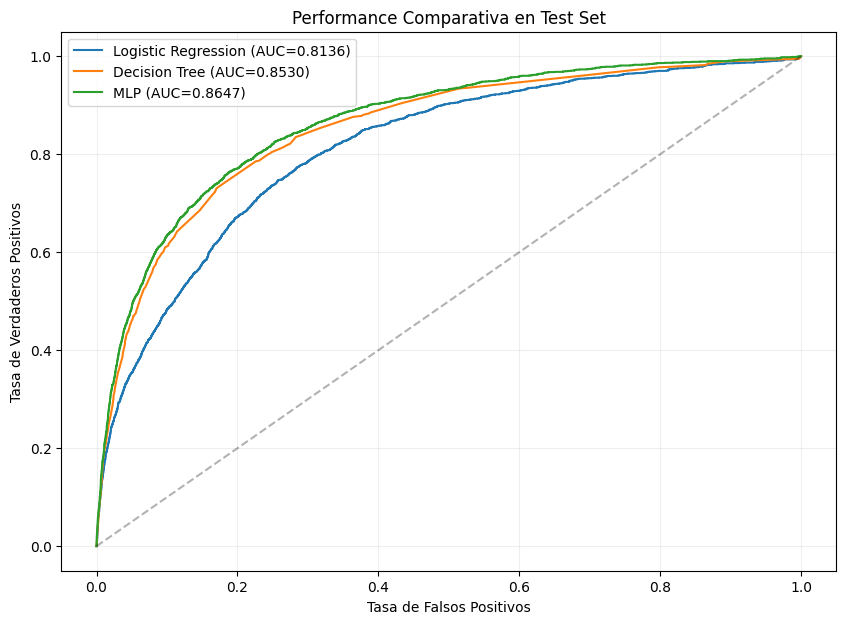

In [17]:
plt.figure(figsize=(10, 7))
for name, model in final_models.items():
    X_te = X_test_scaled if name in ['Logistic Regression', 'MLP'] else X_test
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_te)[:,1])
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc(fpr, tpr):.4f})')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)
plt.title('Performance Comparativa en Test Set')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

## 9. Interpretación de "Caja Negra" con SHAP

Usaremos el modelo MLP para entender qué variables influyen más en el riesgo crediticio.

  0%|          | 0/50 [00:00<?, ?it/s]

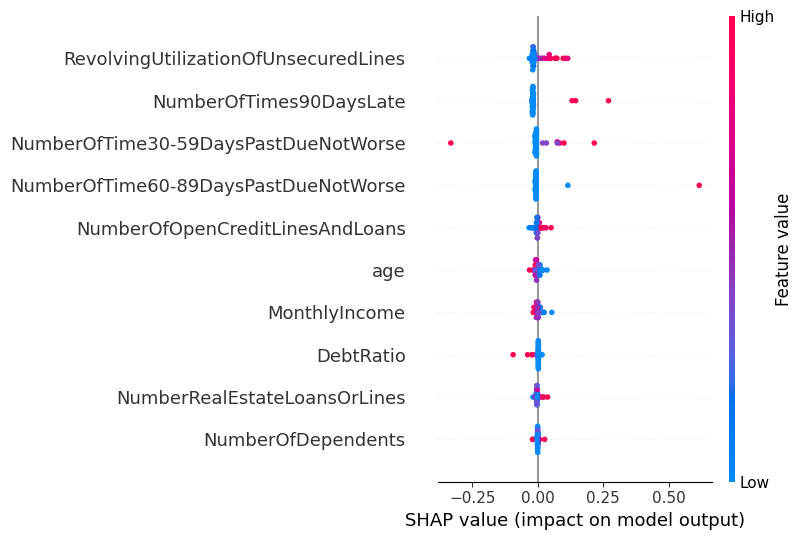

In [21]:
import shap

background = shap.sample(X_test_scaled, 100)
explainer = shap.KernelExplainer(final_models['MLP'].predict_proba, background)
shap_values = explainer.shap_values(X_test_scaled[:50])

# Snippet robusto para corregir el AssertionError en SHAP
import numpy as np

# Detectamos la estructura de los SHAP values (puede ser lista, 3D array o Explanation object)
if isinstance(shap_values, list):
    # Formato lista: [clase_0, clase_1]
    vals_to_plot = shap_values[1]
elif hasattr(shap_values, 'shape') and len(shap_values.shape) == 3:
    # Formato 3D: (muestras, variables, clases)
    vals_to_plot = shap_values[:, :, 1]
else:
    # Formato simple o Explanation object
    vals_to_plot = shap_values

# Graficamos asegurando que la data sea Numpy puro (.values)
# y que los feature_names coincidan exactamente en longitud
shap.summary_plot(
    vals_to_plot, 
    X_test[:50].values, 
    feature_names=list(X.columns)
)


## 10. Conclusiones Académicas

### Interpretación de Resultados
El análisis revela que la **utilización de líneas de crédito** y la **historia previa de morosidad** son los factores determinantes.

### Pros y Contras del Ejercicio

| Técnica / Modelo | Pros | Contras |
| :--- | :--- | :--- |
| **Imputación Iterativa** | Menor sesgo que la mediana; preserva correlaciones. | Lento en datasets masivos. |
| **LazyClassifier** | Panorama rápido de +20 modelos. | No optimiza hiperparámetros. |
| **TPOT (AutoML)** | Descubre pipelines creativos automáticamente. | Muy costoso en tiempo y hardware. |
| **Optuna** | Búsqueda eficiente basada en probabilidad (Bayesiana). | Curva de aprendizaje técnica mayor. |
| **SHAP** | Explicabilidad matemática para modelos complejos. | Computacionalmente pesado. |

### Reflexión Final
Para el Dr. Fuentes: Este flujo demuestra que el valor no está solo en el modelo, sino en la **calidad del preprocesamiento** y la capacidad de **explicar** el porqué de los resultados.